In [1]:
import cmocean.cm as cm
import gsw
import xarray as xr
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from mocsy import mocsy

In [2]:
mesh = nc.Dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
bathy = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc')
tmask = mesh['tmask']
deptht = mesh['gdept_1d'][0]

In [3]:
phys_mean_mar = xr.open_dataset('/data/sallen/results/MEOPAR/averages/SalishSea_mar_climate_2013_2017_grid_T.nc')
phys_mean_apr = xr.open_dataset('/data/sallen/results/MEOPAR/averages/SalishSea_apr_climate_2013_2017_grid_T.nc')

In [4]:
sal_mean = (phys_mean_mar.vosaline[0, 0] + phys_mean_apr.vosaline[0, 0])/2.
temp_mean = (phys_mean_mar.votemper[0, 0] + phys_mean_apr.votemper[0, 0])/2.

In [139]:
bio_mean_mar = xr.open_dataset('/data/sallen/results/MEOPAR/averages/SalishSea_mar_climate_2013_2017_ptrc_T.nc')
bio_mean_apr = xr.open_dataset('/data/sallen/results/MEOPAR/averages/SalishSea_apr_climate_2013_2017_ptrc_T.nc')

In [140]:
nitrate_mean = (bio_mean_mar.nitrate[0, 0] + bio_mean_apr.nitrate[0, 0])/2.

In [5]:
Tinsitu_mean = np.array(gsw.t_from_CT(sal_mean, temp_mean, 0))
Spsu_mean = 35/35.16504 * np.array(sal_mean)
ones = np.ones_like(Spsu_mean.flatten())

In [6]:
chem_mean_mar = xr.open_dataset('/data/sallen/results/MEOPAR/averages/SalishSea_mar_climate_2013_2017_carp_T.nc')
chem_mean_apr = xr.open_dataset('/data/sallen/results/MEOPAR/averages/SalishSea_apr_climate_2013_2017_carp_T.nc')

In [7]:
TA_mean = np.array((chem_mean_mar.total_alkalinity[0, 0] + chem_mean_apr.total_alkalinity[0, 0])/2./1000.)
DIC_mean = np.array((chem_mean_mar.dissolved_inorganic_carbon[0, 0] + 
            chem_mean_apr.dissolved_inorganic_carbon[0, 0])/2./1000.)

In [8]:
def get_pH_Omega(Tinsitu, Spsu, TA, DIC, ones):
    response_tup = mocsy.mvars(temp=Tinsitu.flatten(), sal=Spsu.flatten(), alk=TA.flatten(), 
                           dic=DIC.flatten(), 
                       sil=0.*ones, phos=0.*ones, patm=0.*ones, depth=0.*ones, lat=0.*ones, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup
    return pH, OmegaA

In [9]:
pH_mean, Omega_mean = get_pH_Omega(Tinsitu_mean, Spsu_mean, TA_mean, DIC_mean, ones)

In [141]:
def get_data(year, rerun=False):
    if rerun:
        tdir = '/data/sallen/results/MEOPAR/v201905r/'
    else:
        tdir = '/results/SalishSea/month-avg.201905/'
    phys_mar = xr.open_dataset(f'{tdir}/SalishSea_1m_{year}03_{year}03_grid_T.nc')
    phys_apr = xr.open_dataset(f'{tdir}/SalishSea_1m_{year}04_{year}04_grid_T.nc')   

    sal = (phys_mar.vosaline[0, 0] + phys_apr.vosaline[0, 0])/2.
    temp = (phys_mar.votemper[0, 0] + phys_apr.votemper[0, 0])/2.
    
    bio_mar = xr.open_dataset(f'{tdir}/SalishSea_1m_{year}03_{year}03_ptrc_T.nc')
    bio_apr = xr.open_dataset(f'{tdir}/SalishSea_1m_{year}04_{year}04_ptrc_T.nc')   

    nitrate = (bio_mar.nitrate[0, 0] + bio_apr.nitrate[0, 0])/2.

    Tinsitu = np.array(gsw.t_from_CT(sal, temp, 0))
    Spsu = 35/35.16504 * np.array(sal)

    chem_mar = xr.open_dataset(f'{tdir}/SalishSea_1m_{year}03_{year}03_carp_T.nc')
    chem_apr = xr.open_dataset(f'{tdir}/SalishSea_1m_{year}04_{year}04_carp_T.nc')   

    TA = np.array((chem_mar.total_alkalinity[0, 0] + chem_apr.total_alkalinity[0, 0])/2./1000.)
    DIC = np.array((chem_mar.dissolved_inorganic_carbon[0, 0] + 
            chem_apr.dissolved_inorganic_carbon[0, 0])/2./1000.)

    pH, Omega = get_pH_Omega(Tinsitu, Spsu, TA, DIC, ones)
    return sal, temp, nitrate, TA, DIC, pH, Omega

In [142]:
def plot_pair(Field, year, data, mean_data, cmap, vmax, vmin, dvmax, axs):
    field = np.ma.array(data, mask=1-tmask[0, 0])
    del_field = np.ma.array(data - mean_data, mask=1-tmask[0, 0])
    colours = axs[0].pcolormesh(field, cmap=cmap, vmax=vmax, vmin=vmin)
    cbar = fig.colorbar(colours, ax=axs[0])
    colours = axs[1].pcolormesh(del_field, cmap=cm.balance, vmax=dvmax, vmin=-dvmax)
    cbar = fig.colorbar(colours, ax=axs[1])
    for ax in axs:
        ax.set_title(f'{Field} {year}')

In [145]:
def do_set(year, rerun=False):
    m = 100/18.
    b = 150 - 30*m
    sal, temp, nitrate, TA, DIC, pH, Omega = get_data(year, rerun)
    fig, axs = plt.subplots(2, 8, figsize=(24, 12))
    plot_pair('Salinity', year, sal, sal_mean, cm.haline, 30, 15, 2, axs[:, 0])
    plot_pair('Cons. Temperature', year, temp, temp_mean, cm.thermal, 10, 6, 2, axs[:, 1])
    plot_pair('Nitrate', year, nitrate, nitrate_mean, cm.rain, 20, 0, 2, axs[:, 2])
    plot_pair('Total Alkalinity', year, TA, TA_mean, cm.deep, 2.2, 1, 0.1, axs[:, 3])
    plot_pair('Dissolved Inorganic Carbon', year, DIC, DIC_mean, cm.matter, 2.2, 1, 0.1, axs[:, 4])
    plot_pair('Norm. TA-DIC', year, (TA-DIC)*1000.-(m*sal+b), (TA_mean-DIC_mean)*1000.-(m*sal+b), cm.tarn, 60, -100, 20, axs[:, 5])
    plot_pair('Omega_A', year, Omega.reshape([898, 398]), Omega_mean.reshape([898, 398]), 
          cm.curl, 5, 0.5, 0.5, axs[:, 6])
    plot_pair('pH', year, pH.reshape([898, 398]), pH_mean.reshape([898, 398]), 
          cm.ice, 7.5, 8.5, 0.2, axs[:, 7])

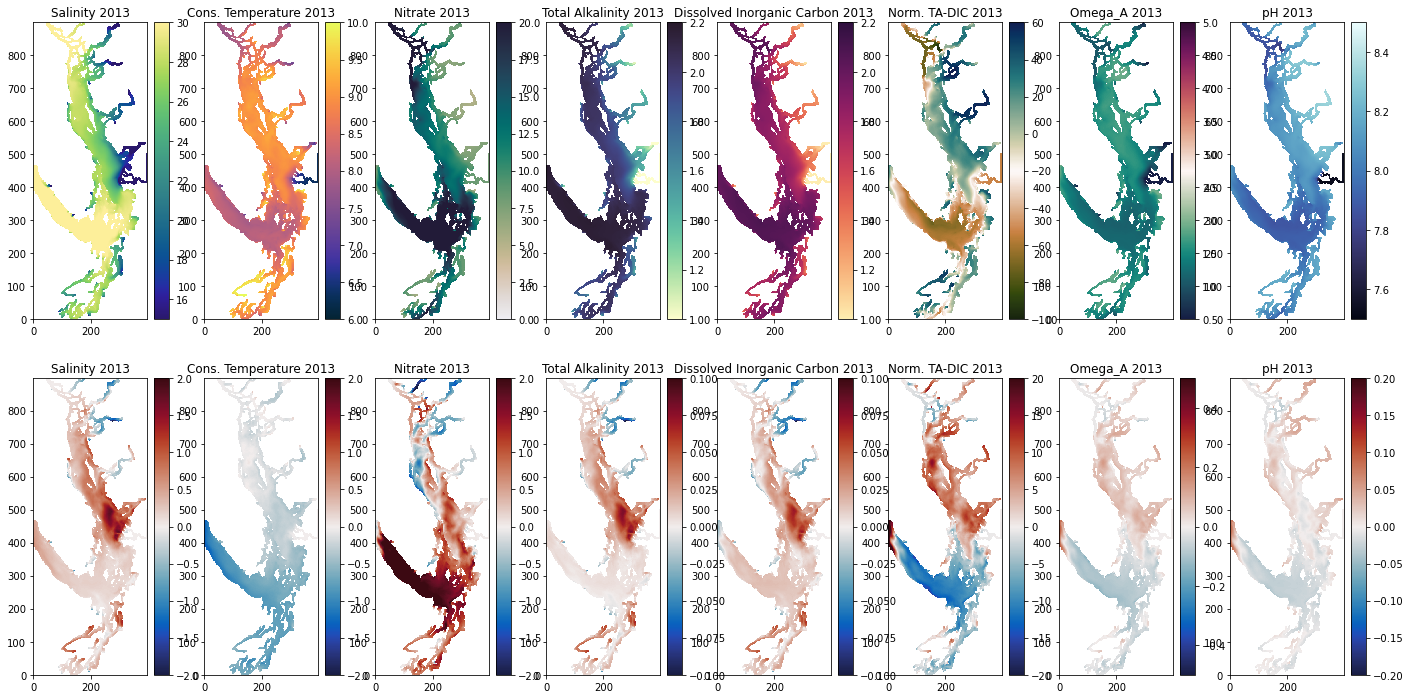

In [179]:
do_set(2013)
# Normalized TA-DIC is explained below: first order take out the dilution effect. 

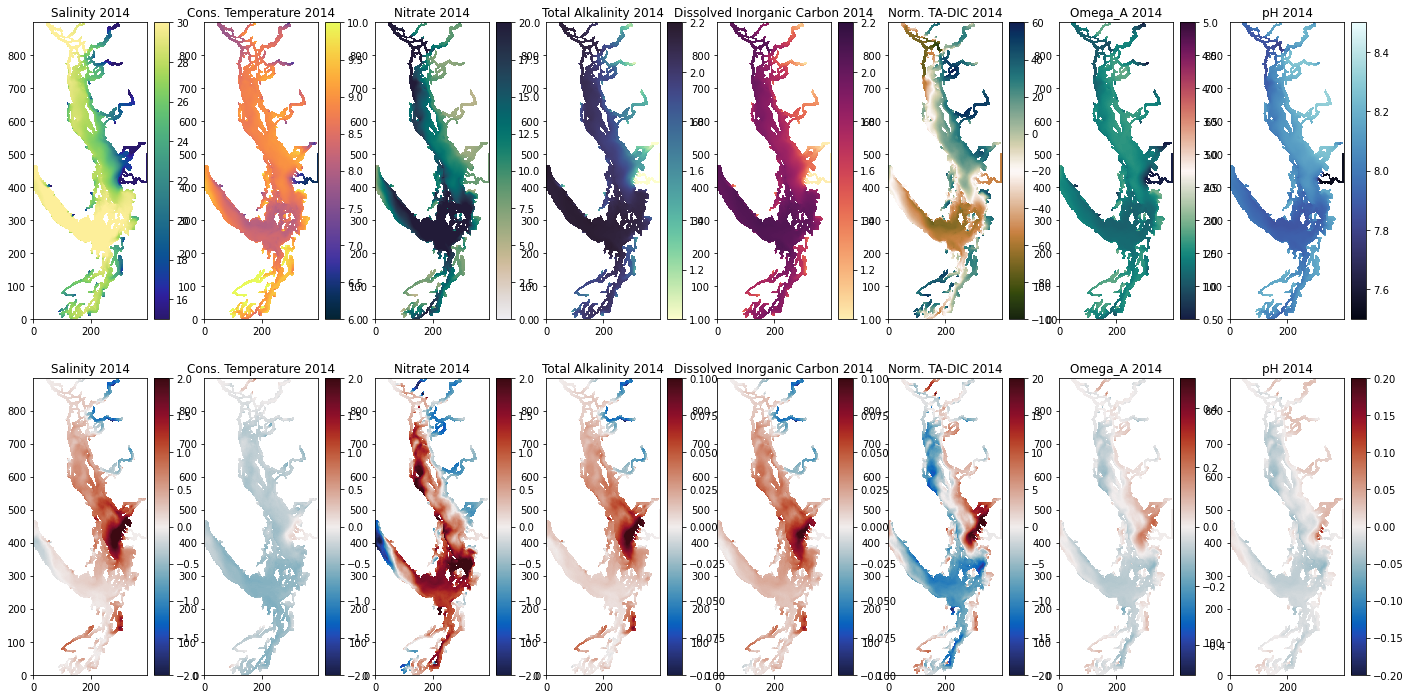

In [147]:
do_set(2014)

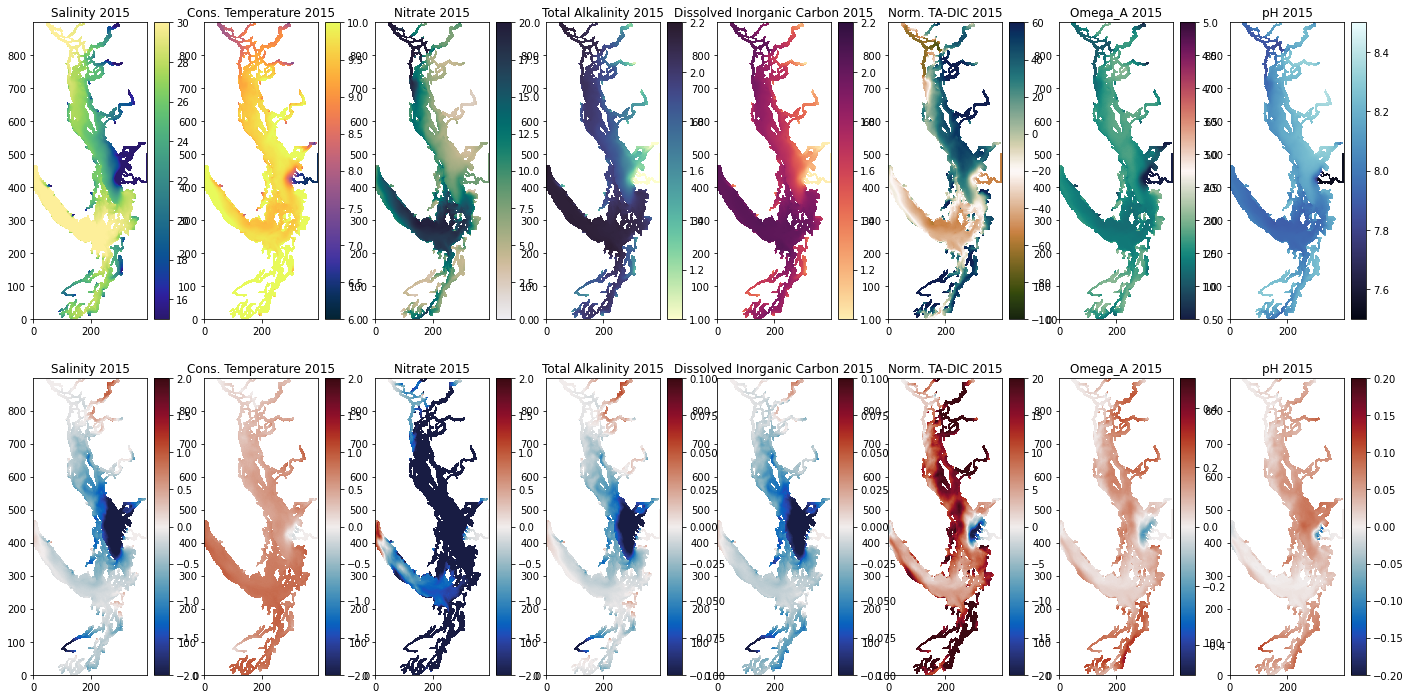

In [148]:
do_set(2015)

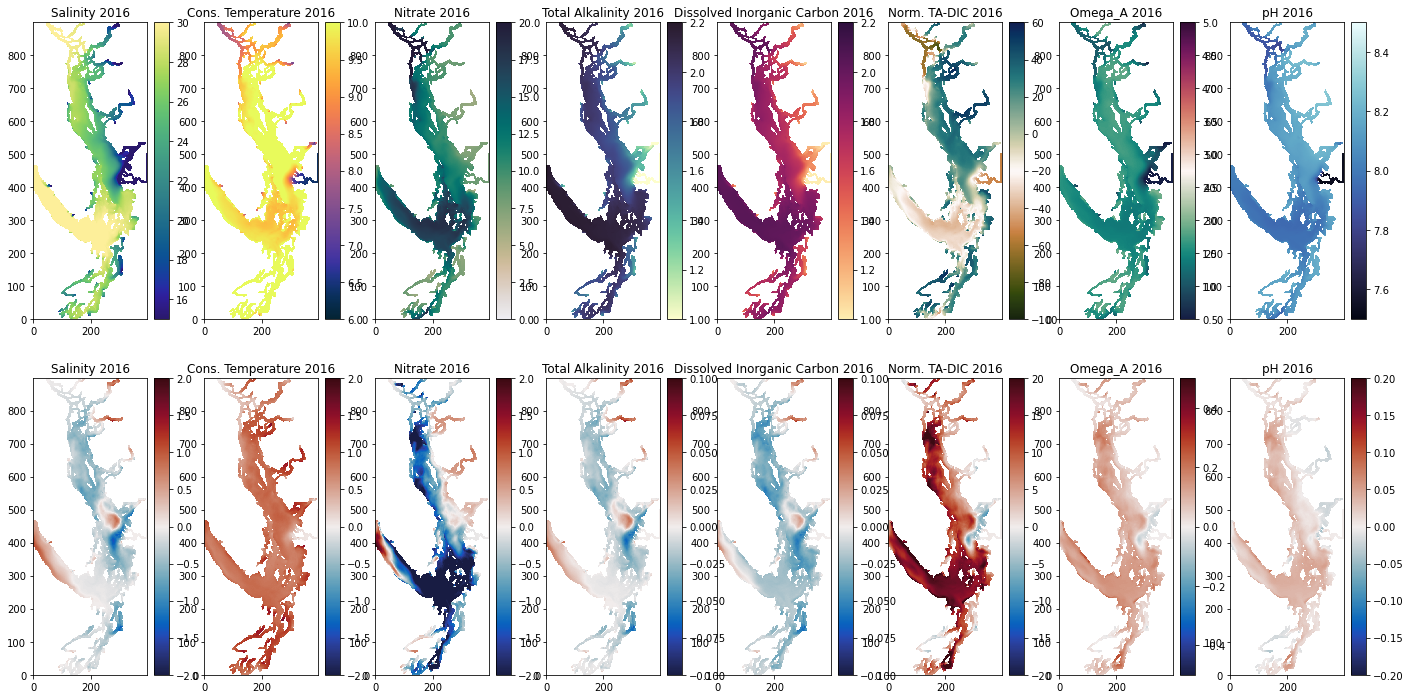

In [149]:
do_set(2016)

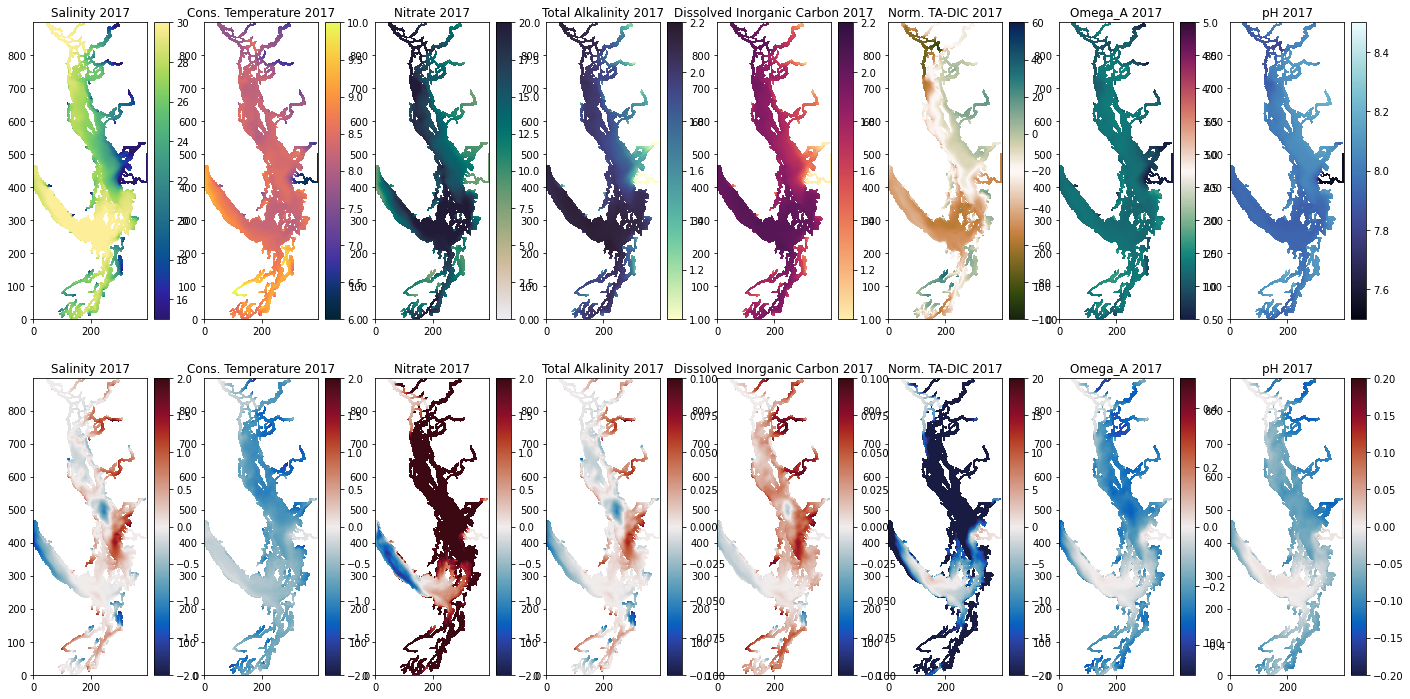

In [150]:
do_set(2017)

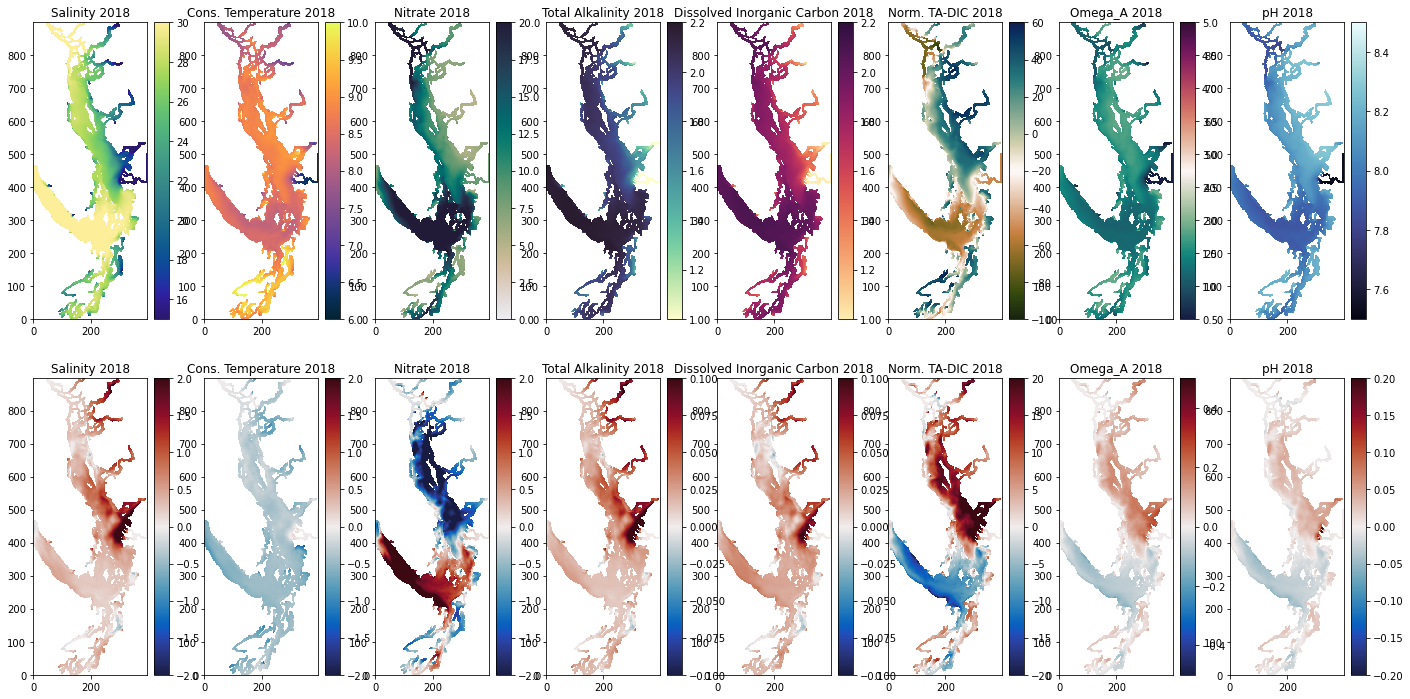

In [151]:
do_set(2018)

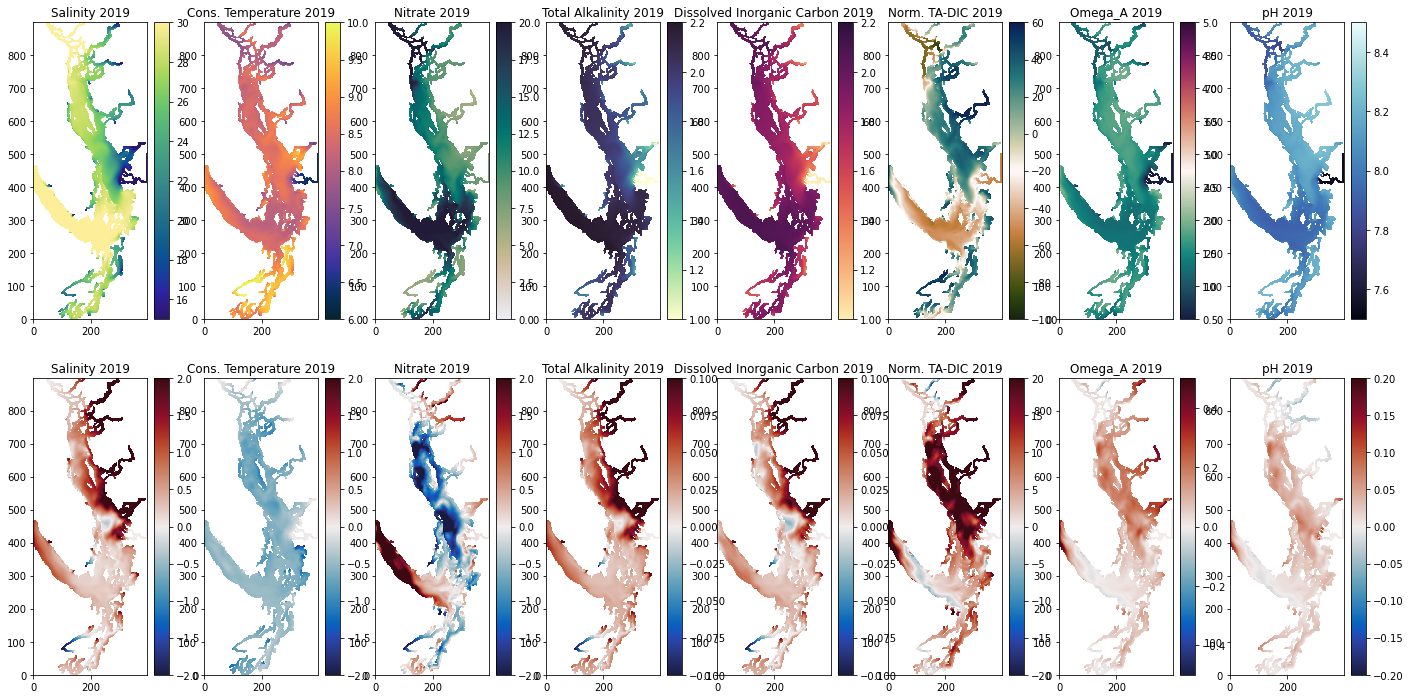

In [152]:
do_set(2019)

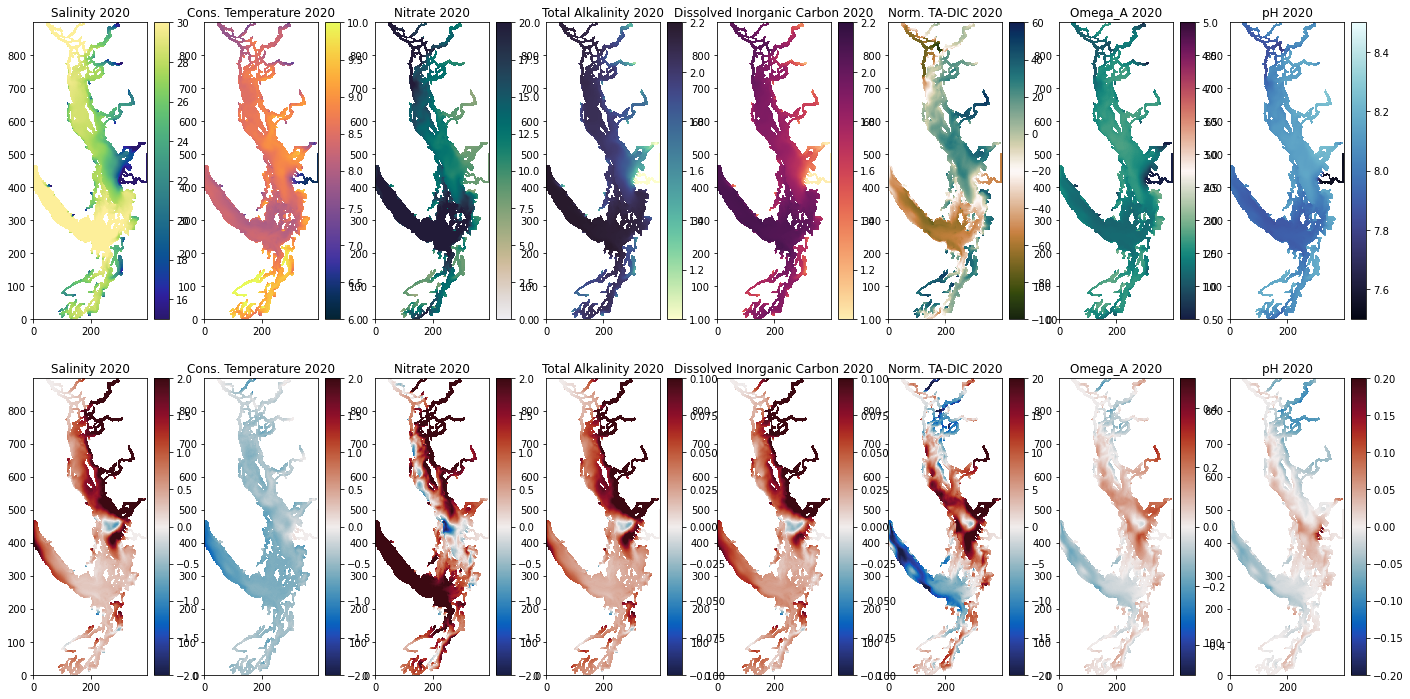

In [153]:
do_set(2020)

### Take some of the dilution Effect Out

Look at the TA-DIC versus Salinity and Fit a line

In [171]:
def do_TDS(year, ax, colour):
    sal, temp, nitrate, TA, DIC, pH, Omega = get_data(year)
    ax.plot(np.array(sal).flatten(), (TA-DIC).flatten()*1000., '*', color=colour, alpha=0.5, label=year)
    ax.grid()
    ax.legend()
    return np.ma.mean(np.ma.array(sal, mask=1-tmask[0, 0])), np.ma.mean(np.ma.array(TA-DIC, mask=1-tmask[0, 0]))

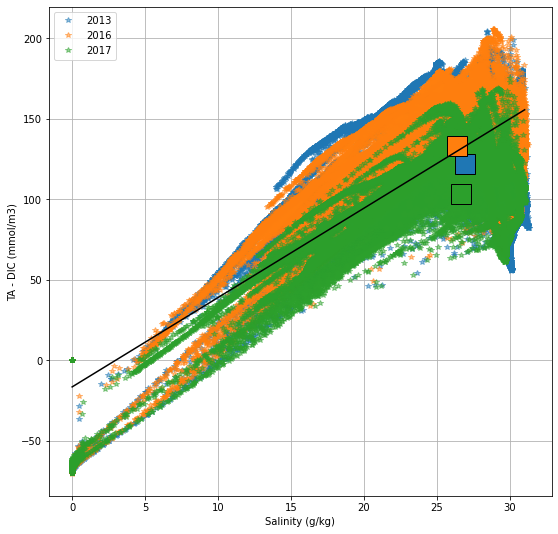

In [174]:
sal = np.zeros((3))
TAmDIC = np.zeros_like(sal)
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
sal[0], TAmDIC[0] = do_TDS(2013, ax, 'tab:blue')
sal[1], TAmDIC[1] = do_TDS(2016, ax, 'tab:orange')
sal[2], TAmDIC[2] = do_TDS(2017, ax, 'tab:green')
for ii in range(3):
    ax.plot(sal[ii], TAmDIC[ii]*1000., marker='s', markersize=20, markeredgecolor='k');
m = 100/18.
b = 150 - 30*m
salrange = np.arange(0, 32)
ax.plot(salrange, m*salrange+b, 'k')
ax.set_ylabel('TA - DIC (mmol/m3)')
ax.set_xlabel('Salinity (g/kg)');

Note that the salinity between the years is not much different but the TA-DIC is.

### Effect of Biology

Looking at normalized TA-DIC (difference from the dilution line above)

In [177]:
def do_TDvS(year, ax, colour):
    sal, temp, nitrate, TA, DIC, pH, Omega = get_data(year)
    m = 100/18.
    b = 150 - 30*m
    sala = np.array(sal).flatten()
    lina = m * sala + b
    ax.plot(np.array(nitrate).flatten(), (TA-DIC).flatten()*1000.-lina, '*', color=colour, alpha=0.5, label=year)
    ax.grid()
    ax.legend()
    return np.ma.mean(np.ma.array(nitrate, mask=1-tmask[0, 0])), np.ma.mean(np.ma.array((TA-DIC).flatten()*1000.-lina, mask=1-tmask[0, 0]))

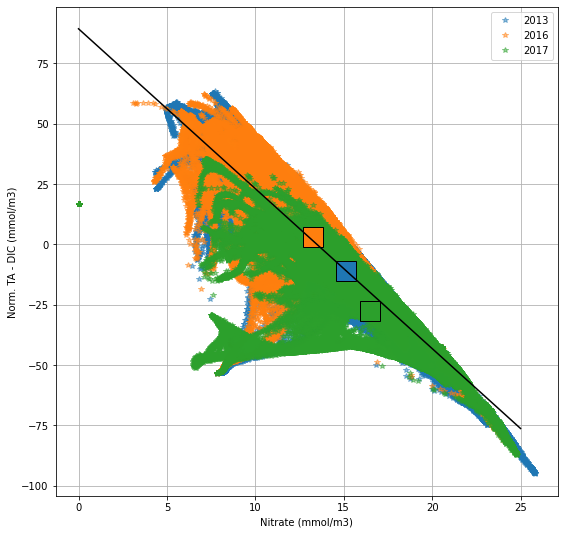

In [183]:
nit = np.zeros((3))
nTAmDIC = np.zeros_like(nit)
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
nit[0], nTAmDIC[0] = do_TDvS(2013, ax, 'tab:blue')
nit[1], nTAmDIC[1] = do_TDvS(2016, ax, 'tab:orange')
nit[2], nTAmDIC[2] = do_TDvS(2017, ax, 'tab:green')
for ii in range(3):
    ax.plot(nit[ii], nTAmDIC[ii], marker='s', markersize=20, markeredgecolor='k');
nitrange = np.arange(0, 25.5)
Redfield_C = -10 - (nitrange-15)*106/16.
ax.plot(nitrange, Redfield_C, 'k')
ax.set_ylabel('Norm. TA - DIC (mmol/m3)')
ax.set_xlabel('Nitrate (mmol/m3)');

Normalized TA-DIC is almost on straight line compared to nitrate and the mean certainly is.  Black line is Redfield. The fact the means are on a straight line implies the mean difference between the years is well captured by dilution and biology.  Largest impact is the biology.